In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
%matplotlib inline

# Load in the data

In [2]:
payments = pd.read_csv(r'payments_npi_by_manufacturer_totals_13.csv')
prescriptions = pd.read_csv(r'prescription_data_npi_13.csv')
drugs = pd.read_csv(r'../drug_manufacturers_cleaned.csv')

In [3]:
forest_payments = payments[payments['manufacturer_cleaned'].str.contains(r'forest pharmaceuticals')]

In [4]:
forest_payments.head()

,NPI,manufacturer_cleaned,Total_Amount_of_Payment_USDollars
9,1003000902,forest pharmaceuticals inc,101.79
56,1003002817,forest pharmaceuticals inc,40.97
105,1003007204,forest pharmaceuticals inc,22.62
153,1003010307,forest pharmaceuticals inc,11.02
166,1003011214,forest pharmaceuticals inc,114.24


In [5]:
prescriptions.head()

,NPI,DRUG_NAME,TOTAL_CLAIM_COUNT,TOTAL_DAY_SUPPLY,TOTAL_DRUG_COST
0,1003000126,ISOSORBIDE MONONITRATE ER,11,307,171.59
1,1003000126,LEVOFLOXACIN,26,165,227.10
2,1003000126,LISINOPRIL,19,570,100.37
3,1003000126,METOPROLOL TARTRATE,30,916,154.65
4,1003000126,PREDNISONE,14,133,44.72


## Isolate drugs only associated with Forest Pharmaceuticals

In [6]:
forest_drugs = drugs[drugs.cleaned.str.contains('forest pharm')].brand_name

In [7]:
drugs.head(2)

,brand_name,generic_name,manufacturer_name,cleaned
0,VARICOGO,"AESCULUS HIPPOCASTANUM, ARNICA MONTANA, CALCAR...","Native Remedies, LLC",native remedies llc
1,DUET DHA,".BETA.-CAROTENE, ASCORBIC ACID, CHOLECALCIFERO...","WH Nutritionals, LLC",wh nutritionals llc


In [8]:
forest_drugs

44852            THYROLAR
59982      ARMOUR THYROID
62709             NAMENDA
70065            DALIRESP
71064          NAMENDA XR
73342             SAPHRIS
75432             TEFLARO
75727             MONUROL
78418            BYSTOLIC
83304    TUDORZA PRESSAIR
Name: brand_name, dtype: object

## Isolate prescription data for Forest Pharmacuetical drugs

In [9]:
forest_prescriptions = prescriptions[prescriptions.DRUG_NAME.isin(forest_drugs)]

In [10]:
forest_prescriptions.head()

,NPI,DRUG_NAME,TOTAL_CLAIM_COUNT,TOTAL_DAY_SUPPLY,TOTAL_DRUG_COST
111,1003000522,NAMENDA,14,945,7912.88
227,1003000530,NAMENDA,13,434,3609.01
325,1003000902,BYSTOLIC,16,960,2195.88
551,1003002312,ARMOUR THYROID,11,532,44.98
558,1003002312,BYSTOLIC,14,420,1466.32


In [11]:
len(forest_prescriptions[forest_prescriptions.NPI.isin(forest_payments.NPI)])

39540

In [12]:
len(forest_prescriptions[~forest_prescriptions.NPI.isin(forest_payments.NPI)])

132480

So there are ~39k prescription entries for forest manufactured products where the provider was paid by forest and ~132k where they were not.

In [13]:
forest_scripts_by_npi = forest_prescriptions.groupby('NPI').agg({'TOTAL_DRUG_COST': 'sum', 
                                         'TOTAL_DAY_SUPPLY': 'sum', 
                                         'TOTAL_CLAIM_COUNT': 'sum'})

In [14]:
forest_data = forest_scripts_by_npi.reset_index().merge(
    forest_payments, on='NPI', how='left').drop('manufacturer_cleaned', axis=1)

## Isolate the groups of prescriptions by providers that were paid by forest and those that were not

In [15]:
paid_by_forest = forest_data[~forest_data.Total_Amount_of_Payment_USDollars.isnull()]
not_paid_by_forest = forest_data[forest_data.Total_Amount_of_Payment_USDollars.isnull()]

In [16]:
len(paid_by_forest)

23659

In [17]:
len(not_paid_by_forest)

101657

So we've got 23k providers who were paid by forest pharmaceuticals and 100k who were not paid by forest.

In [18]:
paid_by_forest.head()

,NPI,TOTAL_DRUG_COST,TOTAL_DAY_SUPPLY,TOTAL_CLAIM_COUNT,Total_Amount_of_Payment_USDollars
2,1003000902,2195.88,960,16,101.79
4,1003002817,133783.76,17896,585,40.97
16,1003010307,100.68,660,16,11.02
23,1003013756,5212.85,1470,48,24.20
31,1003017906,6434.70,769,25,10.69


## Descriptive statistics on both groups

In [19]:
paid_by_forest[['TOTAL_DRUG_COST', 'TOTAL_CLAIM_COUNT', 'TOTAL_DAY_SUPPLY', 'Total_Amount_of_Payment_USDollars']].describe()

,TOTAL_DRUG_COST,TOTAL_CLAIM_COUNT,TOTAL_DAY_SUPPLY,Total_Amount_of_Payment_USDollars
count,2.365900e+04,23659.000000,23659.000000,23659.000000
mean,2.056418e+04,104.393635,3278.035758,261.490011
std,3.091723e+04,173.942240,4262.043548,1816.418405
min,5.446000e+01,11.000000,12.000000,10.000000
25%,5.638360e+03,27.000000,1050.000000,13.890000
50%,1.173389e+04,55.000000,2080.000000,29.040000
75%,2.388809e+04,115.000000,3982.000000,71.225000
max,1.287065e+06,7775.000000,140192.000000,70609.940000


In [20]:
not_paid_by_forest[['TOTAL_DRUG_COST', 'TOTAL_CLAIM_COUNT', 'TOTAL_DAY_SUPPLY']].describe()

,TOTAL_DRUG_COST,TOTAL_CLAIM_COUNT,TOTAL_DAY_SUPPLY
count,101657.000000,101657.000000,101657.000000
mean,12936.576816,64.926262,1907.096353
std,21772.136630,123.012532,2732.073468
min,11.970000,11.000000,11.000000
25%,3318.880000,16.000000,570.000000
50%,6815.210000,31.000000,1080.000000
75%,14232.440000,66.000000,2196.000000
max,962511.280000,7346.000000,130592.000000


## T-tests

In [21]:
st.ttest_ind(paid_by_forest.TOTAL_CLAIM_COUNT, not_paid_by_forest.TOTAL_CLAIM_COUNT, equal_var=False)

Ttest_indResult(statistic=33.030999188121534, pvalue=5.8062159470896435e-235)

In [22]:
st.ttest_ind(paid_by_forest.TOTAL_DAY_SUPPLY, not_paid_by_forest.TOTAL_DAY_SUPPLY, equal_var=False)

Ttest_indResult(statistic=47.267866846677009, pvalue=0.0)

/Users/zakscholl/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


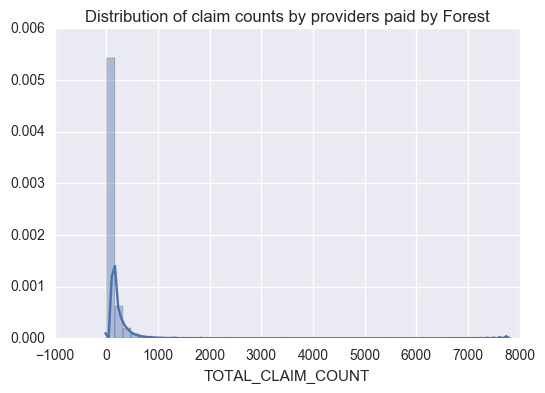

In [23]:
ax = sns.distplot(paid_by_forest.TOTAL_CLAIM_COUNT)
ax.set_title('Distribution of claim counts by providers paid by Forest')
None

/Users/zakscholl/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


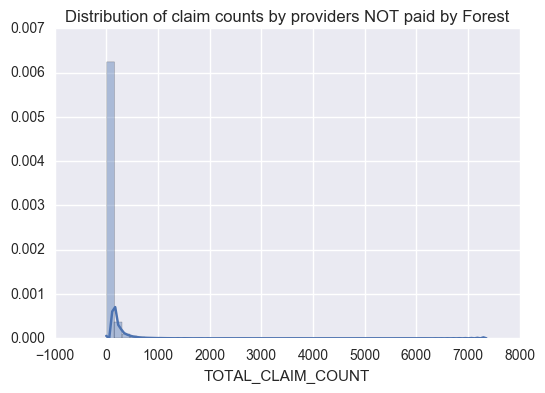

In [24]:
ax = sns.distplot(not_paid_by_forest.TOTAL_CLAIM_COUNT)
ax.set_title('Distribution of claim counts by providers NOT paid by Forest')
None

## Mann-Whitney Tests

In [25]:
# mann-whitney test
st.mannwhitneyu(paid_by_forest.TOTAL_CLAIM_COUNT, not_paid_by_forest.TOTAL_CLAIM_COUNT, alternative='greater')

MannwhitneyuResult(statistic=1537943577.5, pvalue=0.0)

In [26]:
st.mannwhitneyu(paid_by_forest.TOTAL_DAY_SUPPLY, not_paid_by_forest.TOTAL_DAY_SUPPLY, alternative='greater')

MannwhitneyuResult(statistic=1605773823.0, pvalue=0.0)